# Final Project Part 3: 

Group members/role: Daniele Correa, performed analysis to compile list of employees who were hired. Did an investigation to see if anyone was fired or if they changed managers. 

## Hypothesis: Leaker is a fired employee


We will continue the investigation which was done in part 2, which involved compiling a list of the employees who stopped working there (we assume this as being "fired"). We will take a further look at those employees in search of possible suspicious behaivor. For this group of people we will conduct the following investigations:
1. We will check if any employees who were fired logged into a computer in the months after they were fired. 
2. We will do linquistic analysis of the website searches of employees to see if there is odd behaivor there. 



In [1]:
import pandas
import numpy
import matplotlib.pyplot
import sklearn.manifold
import nose.tools
import sklearn.cluster

%matplotlib inline

stopwords = set(open("stop-word-list.txt").read().splitlines())
fired = pandas.read_csv('Fired2.csv')
firedUsers = fired.user_id
logon = pandas.read_csv('logon_info.csv')
devices = pandas.read_csv('device_info.csv')

websites = pandas.read_csv('http_info.csv').sort_values('date')
websites['date'] = websites.date.str.slice(0,10)
websites = websites[websites.user.isin(firedUsers)] #filtering to keep on users in firedUsers


### Question: Did the leaker login into a computer after they stopped working?


Here we will import the list of "fired" employees and the file that contains the logon info. We will then attempt to check if any employees accounts were used after they were fired.

In [2]:
lastLogin  = []
for user in fired.user_id:
    logonUser = logon[logon.user == user]
    date = logonUser.tail(1).date.values
    if date.size > 0: 
        date = date[0]
    else:
        date = 'Never logged in'
    
    lastLogin.append(date)
fired['Last Log in Activity']  = lastLogin
fired

,Unnamed: 0,month,employee_name,user_id,email,role,supervisor,Last Log in Activity
0,74,5/1/17,Ruth Daphne Carver,RDC0283,Ruth.Daphne.Carver@dtaa.com,ProductionLineWorker,Nadine Anjolie Gregory,05/04/2017 17:01:00
1,434,5/1/17,Sonia Nerea Love,SNL0096,Sonia.Nerea.Love@dtaa.com,SystemsEngineer,Evan Bevis Colon,05/07/2017 18:17:00
2,567,5/1/17,Garrison George Guerrero,GGG0825,Garrison.George.Guerrero@dtaa.com,Salesman,Dennis Carson Mendoza,05/07/2017 16:30:00
3,640,5/1/17,Chris L North,CLN1234,Chris.L.North@dtaa.com,Scientist,Emmanuel Casey Wiggins,Never logged in
4,710,5/1/17,Hanae Rhiannon Lindsey,HRL0797,Hanae.Rhiannon.Lindsey@dtaa.com,ProductionLineWorker,Hector Davis Ellison,05/14/2017 15:12:00
5,793,5/1/17,Dominic Zeph Johns,DZJ0261,Dominic.Zeph.Johns@dtaa.com,HardwareEngineer,Evan Bevis Colon,05/19/2017 18:13:00
6,861,5/1/17,Halee Autumn Craft,HAC0651,Halee.Autumn.Craft@dtaa.com,SoftwareEngineer,Gabriel Camden Joseph,05/07/2017 17:15:00
7,1032,6/1/17,Scarlett Kerry Charles,SKC0670,Scarlett.Kerry.Charles@dtaa.com,ProductionLineWorker,Abraham Perry Reyes,06/16/2017 16:43:00
8,1123,6/1/17,Giacomo Hamilton Giles,GHG0667,Giacomo.Hamilton.Giles@dtaa.com,ProductionLineWorker,Abraham Perry Reyes,06/14/2017 16:50:00
9,1544,6/1/17,Ima Quintessa Williams,IQW0294,Ima.Quintessa.Williams@dtaa.com,ProductionLineWorker,Nadine Anjolie Gregory,06/25/2017 16:50:00


Let's check if there is an usage after the month they were said to be fired

In [3]:
count = 0
for index, row in fired.iterrows():
    firedmonth = row.month.split('/')
    firedmonth = int(firedmonth[0])
    lastLogmonth = row['Last Log in Activity'].split('/')
    if(row['Last Log in Activity'] == 'Never logged in'):
        lastLogmonth = firedmonth
    else:
        lastLogmonth = int(lastLogmonth[0])
    if(lastLogmonth != firedmonth):
        print('suspicious user detected')   
        count = count +1
if count == 0:
    print("There are no suspicious logins")

There are no suspicious logins


From this exploration we see that there were no suspicious logins from fired users. What does seem interesting is that there is a scientist "Chris L North" for which there exist no record of him logging in. This is suspicious as you would expect a scientist to use a computer, so we will make note of that. 


In [4]:
websitesChris = websites[websites.user == 'CLN1234']
websitesChris

,id,date,user,pc,url
5264,{F4M8-J9JZ50YF-6407DOUD},05/03/2017,CLN1234,PC-0917,http://easteregg.com/you_found_it/awesome.html


Chris L north was the scientist we took note of earlier, and his only url visited is the easter egg website found above. 

### Question: Did the leaker look up suspicious words in the url?


In this investigation we will filter out the websites visited by the fired employees, and then conduct TFIDF analysis to look for suspicious words employees are looking up. In the stop word list file there exists "filler" words that wont give much insight combined with commonly visited websites such as: google, facebook, twitter, etc. The words in this list will be filted out from the analysis. 

In [5]:


group = websites.groupby('date')

urls = group.url.aggregate(' '.join)
urls = urls.str.lower()
for p in ".,!?:;\"'-~()[]/\\":
    urls = urls.str.replace(p,' ')
urls = urls.apply(lambda t: [w for w in t.split() if w.isalpha() and w not in stopwords]  )
TF = urls.apply(lambda bag: pandas.Series(bag).value_counts())
TF = TF.loc[:,TF.sum() > 5]

IDF = numpy.log( float(len(TF))/TF.count() )

TFIDF = TF * IDF
TFIDF = TFIDF.reindex(sorted(TFIDF.columns), axis=1)

Answer2 = (TFIDF.sum().sort_values(ascending = False))

Answer2

org                   154.307045
hugill                138.327295
patenaude             135.311131
pelileo               131.225317
holmenkollbakken      124.985851
coupons               120.394957
suppan                118.462134
usbank                118.273095
wordpress             114.697948
wikipedia             110.042988
live                  109.430276
varitek               107.648766
tremenheere           107.346948
craigslist            105.787825
tmz                   105.151392
ltcol                 104.744598
googleusercontent     104.417192
huffingtonpost        103.370339
jarratt               101.147179
cnet                  100.732680
knox                  100.276766
hailstorm              99.539898
sokolnitz              98.770616
taua                   98.246939
conatus                97.126314
buridan                97.126314
klotzbachs             96.589657
bodiam                 96.564614
lockheedmartinjobs     95.940916
blogspot               95.027007
          

In the above code, we create a TFIDF table, and we return a list with the words with the highest TFIDF scores. In this list we see that there are some simingly harmless words or websites that employees have been on, but there is one interesting website on that list. That one being "lockheedmartinjobs". We should keep this in mind as it is a bit suspicious that an employee was looking for a job, this might show disinterest from an employee and a possible lack of loyalty. 

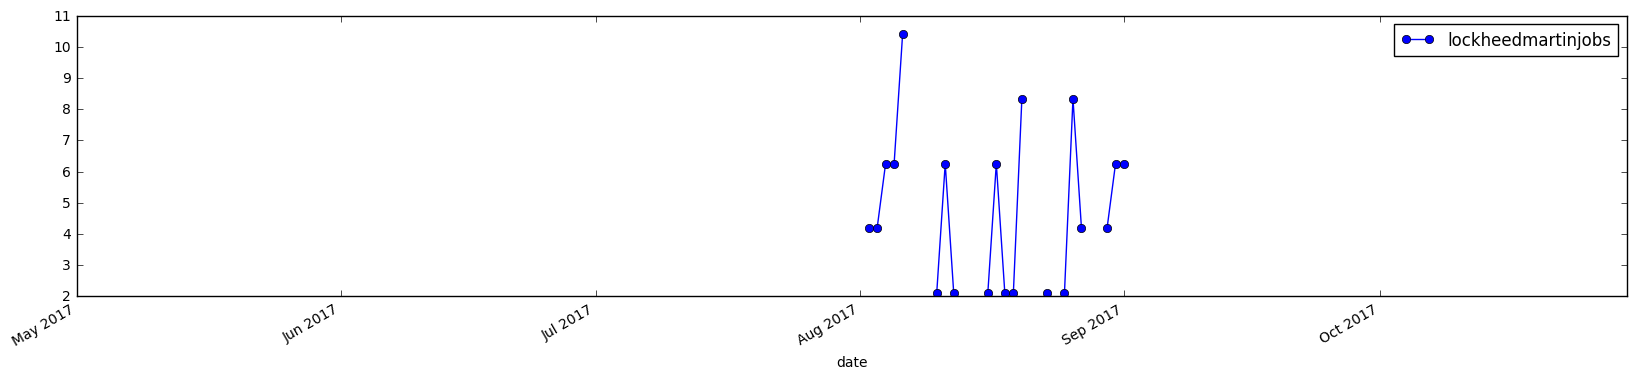

In [6]:
Answer3= pandas.DataFrame({"Word": TFIDF.idxmax(axis=1), 'TFIDF': TFIDF.max(axis =1)}, columns= ['Word','TFIDF'] )
TFIDF_copy = TFIDF.copy()
TFIDF_copy.index = pandas.to_datetime(TFIDF_copy.index)
TFIDF_copy[['lockheedmartinjobs']].plot(legend=True, marker='o', figsize=(20,4))


In the timeseries above we see that the word 'lockheedmartinjobs' started to appear at the start of september and then there were no more  instances once october began. With this we can assume that this employee stopped working/was fired that month. Let's see who it was that was doing this.


In [22]:
websitesLockheed = []
for index, row in websites.iterrows():
    if 'lockheedmartinjobs' in row.url.lower():
        websitesLockheed.append(row)

websitesLockheed = pandas.DataFrame(websitesLockheed)
websitesLockheed.shape


(46, 5)

After filtering out all the instances of 'lockheedmartinjobs' we see that all of these searches are done by the same employee: Cedric Cyrus Harrison. Starting on August 2 and ending on September 1, we see continous visits to lockheedmartinjobs. If we look at the last website he visited:

In [8]:
websitesLockheed.url.values[-1]

'http://lockheedmartinjobs.com/job_application/congratulations.html'

We see the word 'congratulations' which suggests he has been offered a job by Lockheed Martin on 9/1 while his last known login was on 9/30. This gives Cedric a whole month of working at the company while having the possibility of having suspicious motives. 

### Question:  was there a gap in the frequency in which Cedric Cyrus Harrison logged in?

If there exists a gap in the frequency in which Cedric Cyrus Harrison logged in, it would indicate that although his last login was on 9/31, he couldve stopped working before and then logged in to do something suspicious. 

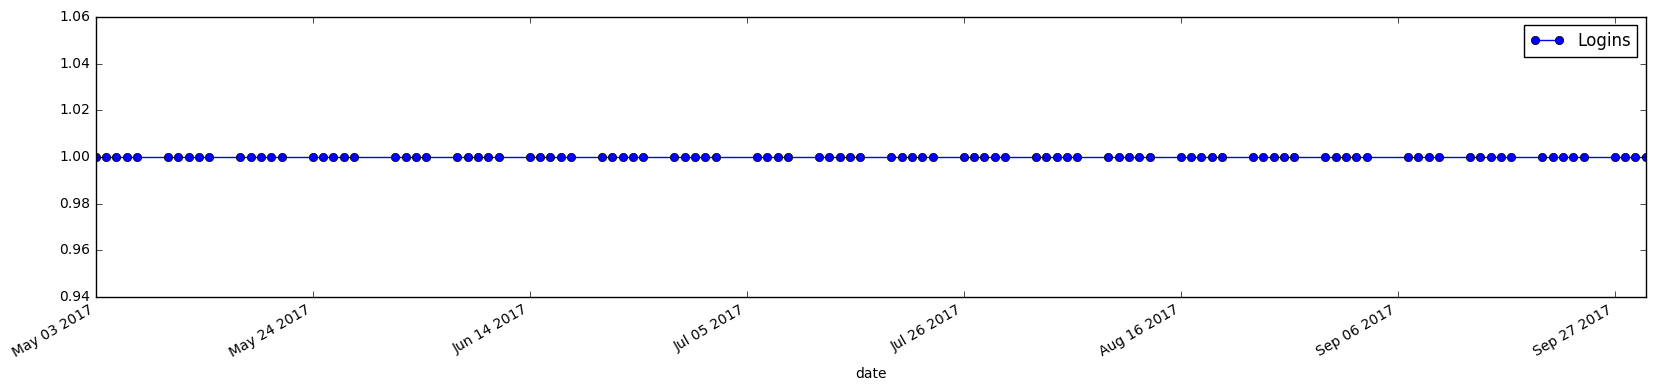

In [9]:
logonCedric = logon[logon.user == 'CCH0959']
logonCedric = logonCedric[logonCedric.activity == 'Logon']
logonCedric['date'] = logonCedric.date.str.slice(0,10)
logonCedric.index = pandas.to_datetime(logonCedric.date)
logonCedric['Logins'] = 1
logonCedric.Logins.plot(legend=True, marker='o', figsize=(20,4))



We can see that Cedric had continously logged everyday(asides from weekends) for the entirery of his employment. Since there was no gap, Cedric is no longer a suspicious employee, as it simply seemed he wanted to change jobs. 

### Question:  did he only log into one computer?

In [10]:
logonLeaker = logon[logon.user == 'CSF0929']

In [11]:
logonLeaker

,id,date,user,pc,activity
1329,{X3W7-C4ZC46DO-6625SSJU},05/03/2017 08:39:00,CSF0929,PC-4442,Logon
2448,{K3H3-D9WT21IV-2957OYXT},05/03/2017 17:41:00,CSF0929,PC-4442,Logoff
3708,{F8R5-B0PL15DI-0585TQOK},05/04/2017 08:33:00,CSF0929,PC-4442,Logon
4962,{P4U6-J4PV07EA-0558ILXF},05/04/2017 17:57:00,CSF0929,PC-4442,Logoff
6205,{C9R3-S6PQ37DZ-3385JKZW},05/05/2017 08:45:00,CSF0929,PC-4442,Logon
7313,{Z3S6-B1YX16HA-8781VIUZ},05/05/2017 17:44:00,CSF0929,PC-4442,Logoff
8572,{H4B9-W6QV61LR-7531RBAD},05/06/2017 08:35:00,CSF0929,PC-4442,Logon
9802,{A7X6-B2KH16YS-7035PUWG},05/06/2017 17:57:00,CSF0929,PC-4442,Logoff
11042,{A9M1-Q6IT70VP-5221ADKL},05/07/2017 08:36:00,CSF0929,PC-4442,Logon
12132,{N4B4-X7SN32TY-5706TZQP},05/07/2017 17:42:00,CSF0929,PC-4442,Logoff


We see that the leaker  always logins into PC-4442. Let's see if anyone else also logins into this computer. 

In [12]:
logonLeakerPC = logon[logon.pc == 'PC-4442']
groupy = logonLeakerPC.groupby('pc')
people = groupy.user.aggregate(' '.join)
TFpeople = people.apply(lambda bag: pandas.Series(bag).value_counts())

loginUsers = TFpeople.columns.values
loginUsers = loginUsers[0].split(' ')
peopleSet = set(loginUsers)
peopleSet

{'CSF0929', 'HKW0211', 'TRW0379', 'UAP0214', 'ZNS0213'}

That is the list of usernames that have shared computers with our suspected leaker. So let's see if they logged in at times near when our leaker leaked. 

In [13]:
logonLeakerPcHKW0211 = logonLeakerPC[logonLeakerPC.user == 'HKW0211']
logonLeakerPcHKW0211

,id,date,user,pc,activity
151790,{H9A7-W3BH82TK-2401ZOYV},07/29/2017 06:34:47,HKW0211,PC-4442,Logon
151827,{J9P8-W8NK23CI-8886JQMX},07/29/2017 06:50:14,HKW0211,PC-4442,Logoff


In [14]:
logonLeakerPcTRW0379 = logonLeakerPC[logonLeakerPC.user == 'TRW0379']
logonLeakerPcTRW0379

,id,date,user,pc,activity
107947,{M1V0-J6HN20RL-6295QZXL},07/02/2017 08:13:54,TRW0379,PC-4442,Logon
107995,{M4Q1-P9XG28IJ-1312OPIE},07/02/2017 08:21:16,TRW0379,PC-4442,Logoff


In [15]:
logonLeakerPcUAP0214 = logonLeakerPC[logonLeakerPC.user == 'UAP0214']
logonLeakerPcUAP0214

,id,date,user,pc,activity
22389,{Z8C5-Y0FF74FG-6920HULO},05/13/2017 18:02:23,UAP0214,PC-4442,Logon
22455,{D2P8-B3ZG14EN-5751UQGO},05/13/2017 18:21:02,UAP0214,PC-4442,Logoff
127141,{L0E3-Z3BM64JK-4070KGPU},07/14/2017 22:31:57,UAP0214,PC-4442,Logon
127143,{N8V2-T6OO80VA-8175PWVI},07/14/2017 22:36:50,UAP0214,PC-4442,Logoff
154054,{Q8F8-L8FT32RF-0111OTTR},07/29/2017 19:57:16,UAP0214,PC-4442,Logon
154060,{J2L1-D9CP10QN-3783POER},07/29/2017 20:05:54,UAP0214,PC-4442,Logoff


In [16]:
logonLeakerPcZNS0213 = logonLeakerPC[logonLeakerPC.user == 'ZNS0213']
logonLeakerPcZNS0213

,id,date,user,pc,activity
38171,{S1X0-F8BZ76CX-0544NCVD},05/24/2017 06:01:33,ZNS0213,PC-4442,Logon
38174,{K0W1-K8VP96LV-7799RYXL},05/24/2017 06:18:48,ZNS0213,PC-4442,Logoff
67989,{G4Q8-T8CZ18NO-3313KCTL},06/09/2017 23:19:21,ZNS0213,PC-4442,Logon
67991,{Z7P9-J7VL07FW-2344BHEC},06/09/2017 23:31:20,ZNS0213,PC-4442,Logoff
119593,{K5B8-B4QL39IL-5107RTAT},07/09/2017 21:01:20,ZNS0213,PC-4442,Logon
119594,{K3T6-U9KA74HR-9840TVJG},07/09/2017 21:11:00,ZNS0213,PC-4442,Logoff


We see that none of these users logged in at times near when our suspect uploaded to WikiLeaks, this let’s us know that there was likely no collaboration with these people. 

### Question : Did  the leaker log in at unsual hours and login a large amont of devies?


In order to test this hypothesis we will get the average hour of login for the fired users, and plot it against the total amount of devices connected. We will then use clustering to determine a suspicious group of people.

In [17]:
logonTime = logon[logon.activity == 'Logon']
logonTime['time'] = logonTime.date.str.slice(11)
logonTime['time'] = logonTime.time.apply(lambda x: int(x.split(':')[0]) + float(int(x.split(':')[1])/60))
averageTime = logonTime.groupby(['user'])['time'].agg(lambda x: x.unique().mean())

deviceNum = devices[devices.activity == 'Connect'] 
deviceNumPerson = deviceNum.groupby(['user'])['id'].nunique()

timeDevices = pandas.DataFrame(averageTime)

deviceList = []
for user in timeDevices.index.values:
    try:
        deviceList.append(deviceNumPerson[user])
    except KeyError:
        deviceList.append(0)
timeDevices['devices'] = deviceList
timeDevices

C:\Users\dan\Anaconda3\lib\site-packages\ipykernel\__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
C:\Users\dan\Anaconda3\lib\site-packages\ipykernel\__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


,time,devices
user,,
AAC0070,7.391667,0
AAP0946,11.692298,0
AAR0716,10.460580,0
AAS0850,12.129808,120
ABG0865,11.738490,0
ABH0821,11.263699,58
ABM0089,8.246111,0
ABM0173,7.158333,0
ABS0125,12.741296,0


Now that we have a table with the average time a given user logins and the toal amount of times a user has connected a device we can plot these values and see if we can classify them. 

In [18]:
normalized = timeDevices.copy(deep = True)

for column in normalized: 
    if normalized[column].dtype.kind in 'bifc':
        normalized[column] = (normalized[column] - normalized[column].mean())/ normalized[column].std()
    else:
        del normalized[column]

        
normalized.time = normalized.time.abs()
km = sklearn.cluster.KMeans(n_clusters = 8, n_init=1) #kinits initialization does not work, cannot find proper way to do it
labels = km.fit_predict(normalized)
                                 
normalized['Cluster'] = labels
normalized

,time,devices,Cluster
user,,,
AAC0070,1.078707,-0.317747,2
AAP0946,1.302546,-0.317747,2
AAR0716,0.620545,-0.317747,5
AAS0850,1.544794,0.154598,3
ABG0865,1.328122,-0.317747,2
ABH0821,1.065231,-0.089447,2
ABM0089,0.605603,-0.317747,5
ABM0173,1.207904,-0.317747,2
ABS0125,1.883374,-0.317747,6


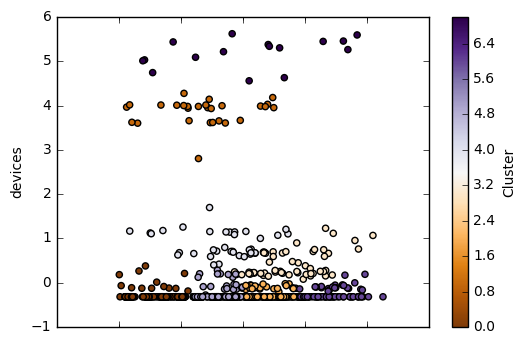

In [19]:
ax = normalized.plot.scatter(x = 'time', y = 'devices', c = 'Cluster', cmap = 'PuOr')


As the data is standarized it does not show the number of devices connected but rather the standard deviation of devices connected. The time is the X axis and it is also standarized and taken the absolute value of. So people who login at times outside of the average will be further to the right. The top right corner of this graph represents the most suspicious group of people as they connected a large amount of devices and logged in at times outside of the norm. Whoever those people are, they might be our leaker so let's filter that group out. 

In [20]:
suspects = normalized[(normalized.Cluster == 7)]
print(suspects.index.values)

['ATV0292' 'AYN0502' 'BGR0068' 'CMR0739' 'CTR0215' 'CZB0191' 'HAM0510'
 'JKD0625' 'JZA0447' 'LAG0639' 'MQF0815' 'NUG0614' 'PCM0369' 'SDH0288'
 'WHC0684' 'YXG0504']


The list above contains the usernames of people this investigation consiters suspicious, as they were classified as having the must unsual amount of devices and average login times. Out of this list, we should check if any of them were fired, as that would allow us to focus on who to continue investigating. The code below prints those users, if any. 

In [21]:
for suspect in suspects.index.values:
    if(suspect in fired.user_id):
        print(suspect)